In [3]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

# 1. Load pretrained MobileNetV2 (trained on ImageNet)
# The output layer is a Dense layer with 1000 nodes (Softmax activation)
model = MobileNetV2(weights='imagenet')

def extract_frames(video_path, max_frames=20):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return np.array([])

    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate step to pick frames evenly across the video
    if total_frames > 0:
        step = max(1, total_frames // max_frames)
    else:
        step = 1

    count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if count % step == 0:
            # Resize to 224x224 as required by MobileNetV2 input layer
            frame = cv2.resize(frame, (224, 224))
            # Convert BGR (OpenCV default) to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

        count += 1
        if len(frames) >= max_frames:
            break

    cap.release()
    return np.array(frames)

def classify_video(video_path):
    print(f"Processing: {video_path}")
    frames = extract_frames(video_path)

    if len(frames) == 0:
        print("No frames extracted!")
        return

    # Display internal frame size for verification
    print(f"Input Tensor Shape: {frames.shape} (Frames, Height, Width, Channels)")

    # 2. Preprocess frames for the model (scales pixel values to [-1, 1])
    processed_frames = preprocess_input(frames.astype('float32'))

    # 3. Get predictions for each frame
    predictions = model.predict(processed_frames)

    # 4. Average predictions across all extracted frames
    avg_pred = np.mean(predictions, axis=0)

    # 5. Decode the top 5 predicted classes
    top_preds = decode_predictions(np.expand_dims(avg_pred, axis=0), top=5)[0]

    print("\n--- Predictions ---")
    for i, (imagenet_id, label, score) in enumerate(top_preds):
        print(f"{i+1}. {label}: {score*100:.2f}%")

    print(f"\nFinal Video Classification: {top_preds[0][1]}")

# --- Run the Script ---
# Ensure you have a 'video.mp4' file in your directory
video_file = "video.mp4"
classify_video(video_file)


Processing: video.mp4
Input Tensor Shape: (20, 224, 224, 3) (Frames, Height, Width, Channels)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Predictions ---
1. cab: 17.92%
2. traffic_light: 6.14%
3. streetcar: 5.89%
4. jinrikisha: 3.63%
5. limousine: 3.56%

Final Video Classification: cab


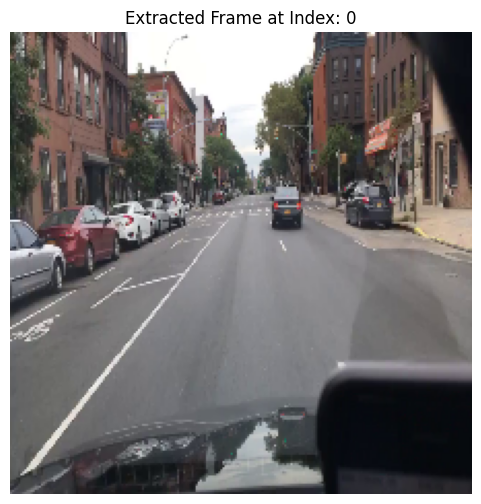

In [4]:
import matplotlib.pyplot as plt

def show_frame(frames, index=0):
    """
    Displays a single frame from the extracted frames array.
    """
    if len(frames) == 0:
        print("No frames available to display.")
        return

    # Select the specific frame
    frame = frames[index]

    # Display using Matplotlib
    plt.figure(figsize=(6, 6))
    plt.imshow(frame) # Frames are already RGB from your earlier 'Important fix'
    plt.title(f"Extracted Frame at Index: {index}")
    plt.axis('off') # Hide pixel coordinates
    plt.show()

# --- Example Usage ---
# After running classify_video(video_path):
frames = extract_frames("video.mp4")
show_frame(frames, index=0) # Shows the first extracted frame


In [6]:
# Extract frames using your existing function
frames = extract_frames("video.mp4")

# Select the first frame
first_frame = frames[0]

# Get the RGB value of the center pixel
pixel_value = first_frame[112, 112]
print(f"RGB value at (112, 112): {pixel_value}")


RGB value at (112, 112): [150 149 152]


In [7]:
frames = extract_frames("video.mp4")
first_frame = frames[0]

# Print the array (shows corners)
print(first_frame)


[[[ 60  67  53]
  [ 57  63  50]
  [125 131 119]
  ...
  [  8  13  19]
  [  8  13  19]
  [  8  13  19]]

 [[ 55  61  48]
  [ 60  66  53]
  [ 83  89  77]
  ...
  [  8  13  19]
  [  8  13  19]
  [  8  13  19]]

 [[ 48  54  41]
  [ 62  67  55]
  [ 68  74  63]
  ...
  [  8  12  19]
  [  8  12  19]
  [  8  12  19]]

 ...

 [[ 47  46  50]
  [ 52  52  60]
  [ 80  80  88]
  ...
  [ 41  39  45]
  [ 39  37  43]
  [ 32  32  37]]

 [[ 85  84  89]
  [100 100 108]
  [ 77  77  85]
  ...
  [ 42  39  45]
  [ 38  35  41]
  [ 34  33  38]]

 [[114 113 118]
  [ 78  78  86]
  [ 73  73  81]
  ...
  [ 42  39  45]
  [ 40  37  43]
  [ 36  35  40]]]


In [8]:
import cv2
import numpy as np

def extract_20_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return np.array([])

    # Get total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the step to pick 20 frames evenly across the duration
    # If video has 200 frames, step = 10 (take every 10th frame)
    max_frames = 20
    step = max(1, total_frames // max_frames)

    frames = []
    count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Only keep the frame if it matches our step interval
        if count % step == 0 and len(frames) < max_frames:
            # Resize and convert to RGB for MobileNetV2
            frame = cv2.resize(frame, (224, 224))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

        count += 1
        if len(frames) >= max_frames:
            break

    cap.release()
    print(f"Successfully extracted {len(frames)} frames.")
    return np.array(frames)

# Usage
video_path = "video.mp4"
frames_array = extract_20_frames(video_path)

# Verify the shape: (20, 224, 224, 3)
print("Final Array Shape:", frames_array.shape)


Successfully extracted 20 frames.
Final Array Shape: (20, 224, 224, 3)


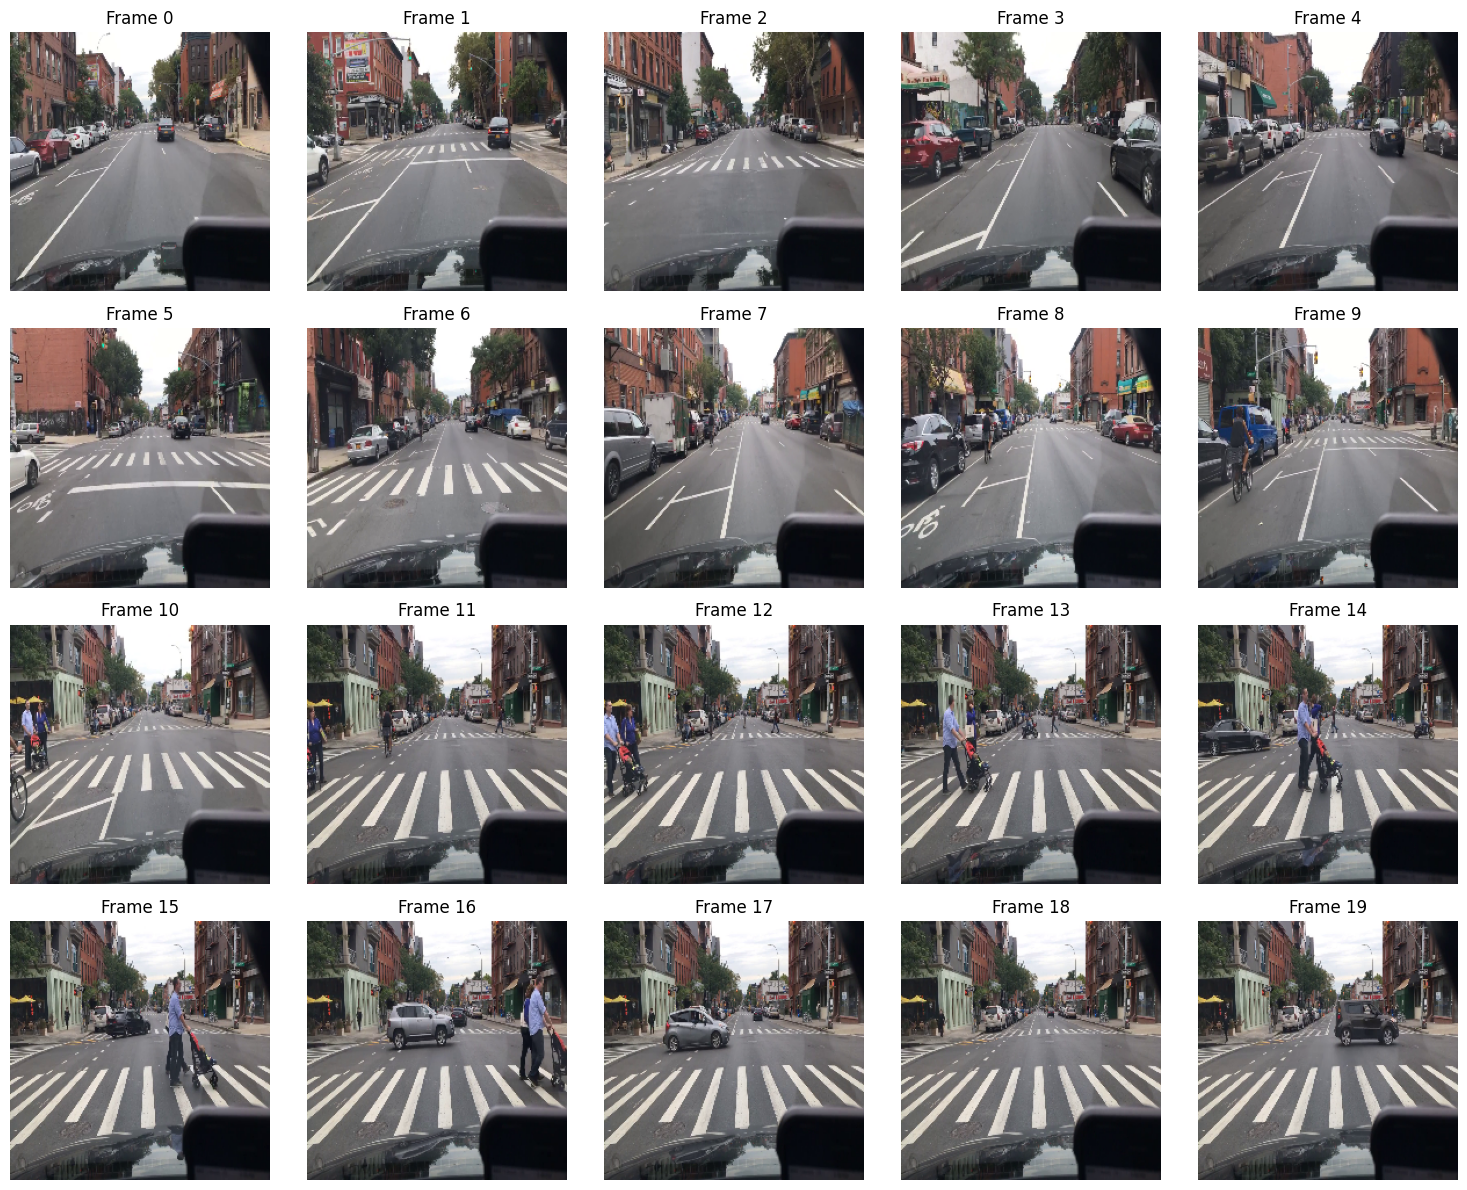

In [9]:
import matplotlib.pyplot as plt

def display_20_frames(frames):
    if len(frames) < 20:
        print(f"Warning: Only {len(frames)} frames found. Adjusting grid.")

    # Create a figure with a 4x5 grid
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12))

    # Flatten the axes array to easily iterate through it
    for i, ax in enumerate(axes.flat):
        if i < len(frames):
            ax.imshow(frames[i])
            ax.set_title(f"Frame {i}")
        ax.axis('off') # Hide x and y ticks for a cleaner look

    plt.tight_layout()
    plt.show()

# --- Execution ---
# 1. Extract the frames first
video_frames = extract_frames("video.mp4", max_frames=20)

# 2. Display them all at once
display_20_frames(video_frames)
